Copyright (c) 2023, University of Cambridge, all rights reserved. Written by Andrew Wheeler, University of Cambridge



# Desktop DNS Notebook 2: Running in 3D

---
### User agreement and correct use of these tools
This notebook and associated Python code are provided for non-commericial/academic use only. For those interested in commercial application of these tools please contact Andrew Wheeler (e-mail: aw329@cam.ac.uk). Please read the license agreement (LICENSE.txt).


If you use these tools for a publication please include the citation:

*Wheeler A.P.S. (2023) 'Desktop-DNS: An open toolkit for turbomachinery aerodynamics', ASME Turbo Expo 2023, ASME Paper no. GT2023-1023647*

---

## 2.0 Introduction

In Notebook 1 you established a two-dimensional unsteady flow; you saw that because the flow is purely two-dimensional there can be no breakdown to turbulence and therefore unsteady structures (such as vortices) persist and dominate the flow - this is not what happens in a real flow (with the exception of flows at very low Reynolds numbers) because usually turbulent breakdown occurs, increasing viscous dissipation through the creation of fine-scale motion. 

The process leading to the growth of instabilities and eventual turbulent breakdown requires some spanwise extent (3D). In many cases, the initiation of three-dimensional instabilities will be driven by the perturbing effects of freestream turbulence - this plays an important role in breaking-up initially two-dimensional instabilities. 

Therefore both three-dimensionality and freestream turbulence are vital to establishing a realistic flow. 

In this notebook you will
* establish a 3D flow
* add inflow turbulence
* create probe files
* gather statistics

---

## 2.1 Running in 3D

### Create the new case files
First we need to create the new case files. In the following cells the grid and case details are copied to a new 'notebook2' directory. The case is updated to increase the spanwise points from 1 (for the 2D case) to 21 and the span is set to 10 percent of the axial chord. This produces a relatively coarse grid which we will use to establish a prelimary 3D case. 

We set the 'irestart' value to 12 which means that the previous 2D flow is read in and extruded during runtime. 

The case is also adjusted in order to run the simulation on 4 GPUs. To do this, 4 block groups are defined. Each block group contains a similar number of grid points so that each GPU has a similar load (i.e. the GPUs are load balanced).


In [99]:
# this cell ensures that python modules are reloaded at runtime

# reload modules
%reload_ext autoreload
%autoreload 2

In [101]:
from meshing.write_flo import *
from meshing.write_case import *
from meshing.read_case import *

casename_old = 'notebook1'
casename_new = 'notebook2'

# read casefiles and flow from old directory
case = read_case(casename_old)
prop,_=read_flo(casename_old)

# copy files to new directory
case['casename'] = casename_new 
write_case(case)

# write flow files to new directory
write_flo(prop,casename_new)

# set number of spanwise point
case['solver']['nk'] = 21 # spanwise points for 3D calculation 
case['solver']['span'] = 0.1 # set the spanwise extent (in this case the axial chord is 1.0m, so span=10%cax)


# adjust iterations 
case['solver']['niter'] = 100000 # total number of iterations
case['solver']['nwrite'] = 10000 # write flow every nwrite iterations
case['solver']['irestart'] = 12 # restart the calculation with irestart=12, which extrudes the 2D flow
case['casename'] = casename_new # copy files to new directory

      
# define block groups for each GPU card
block_groups = 4*[None] # 4 block groups (4 GPUs)

# blocks in each block group
block_groups[0] = {}
block_groups[0]['blocks'] = [1,8]

block_groups[1] = {}
block_groups[1]['blocks'] = [2,4]

block_groups[2] = {}
block_groups[2]['blocks'] = [5,9]

block_groups[3] = {}
block_groups[3]['blocks'] = [3,6,7]


case['solver']['block_groups'] = block_groups
case['solver']['nkproc'] = 1 # GPUs in spanwise direction

# write new case files
write_case(case)



Writing inputs for 3dns_gpu
Total ij points
259504
Total GPUs
1
Writing inputs for 3dns_gpu
Total ij points
259504
Total GPUs
4



### Re-start the case 

The case is now set-up to run on 4 GPUs. We can now launch a new AWS instance, but this time we need to select one which has 4 GPUs. A suggestion is shown in the table below. This also shows an estimate of the price (based on typical costs for the N. Virginia region). Further details on how to launch an AWS instance is given in Notebook 1.




| VM instance | GPU  | approx. \$/hr*| time per step(s)|\$ for 100k steps* | 
|-------------|------|---------------|--------|----|
| p3.8xlarge  |4 x V100 | 3.6 (12)   | 0.026  | 2.7 (8.8) | 

*Estimated spot price (values in brackets are the estimated on-demand price) for a 5.4M point grid



It's possible to run the case on fewer or more GPUs - you just need to adjust the case details (block groups) above and make sure you select an appropriate instance. You can find more information in the 3DNS-gpu userguide about this. 

The recommendation in the table above is a good fit for this size of job. Running on a smaller machine with fewer GPUs will tend to cost the same because the compute time and cost scale pretty much linearly with number of GPUs. Requesting a much larger machine with more GPUs will mean the GPUs are likely to be underutilized.

Once launched, copy the case files and *3DNS-gpu* executible to the instance.




To run *3DNS-gpu* on 4 GPUs using the command:

> mpirun -np 4 threedns_#


### View the flow
Once complete, copy the files ('flow_*','span_*','monitor.txt','time.txt') to your notebook2 directory.

You can check the flow by plotting out different flow properties.

In [2]:
from postpro.read_flo import *

casename = 'notebook2'

# read flo
prop,geom=read_flo(casename)

<module 'matplotlib.pyplot' from '/home/aw329/.local/lib/python3.6/site-packages/matplotlib/pyplot.py'>

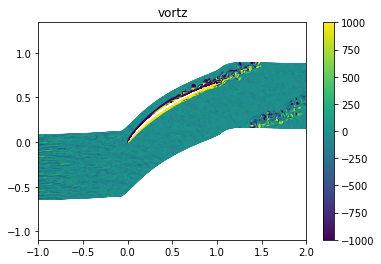

In [4]:
from postpro.plot_flo import *

# pop-out figure
#%matplotlib qt
%matplotlib inline

plot_flo(prop,geom,'vortz',[-1000,1000])
#plot_flo(prop,geom,'p',[0.96e5,1.0e5])

When setting 'irestart=12', such that the flow is extruded from a 2D flow, a small spanwise pulse is introduced in the flow in order to excite any global instabilities

$\rho   = \rho_{2D} (1 + \delta(k))$

$\rho u = \rho u_{2D} (1 + \delta(k))$

$\rho v = \rho v_{2D} (1 + \delta(k))$

$\rho w = \rho w_{2D} (1 + \delta(k))$

$E_t = E_{t2D} (1 + \delta(k))$

where 
$\delta(5 \leq k \leq 10) = - 1 \times 10^{-8}$, otherwise $\delta(k<5|k>10) = 1 \times 10^{-8}$ 



An important observation can be made here. Notice that despite the fact that the domain is now 3D (i.e. there is a spanwise extent) we don't yet see any significant develoment of three-dimensionality in the flow. 

Verify this by plotting the spanwise velocity 'w' below. Only very small levels of spanwise motion is observed over the blade.

The small initial perturbation isn't sufficient to drive a significant growth in three-dimensional instabilities. We could repeat this calculation with a larger initial pulse, but what we really need is a  more physical means to drive transition. At the moment the flow is too `clean' to drive turbulent breakdown. 

In order to get a realistic breakdown to turbulence, inflow turbulence is necessary.



In [179]:
plot_flo(prop,geom,'w',[-1,1])


<module 'matplotlib.pyplot' from '/home/aw329/.local/lib/python3.6/site-packages/matplotlib/pyplot.py'>


---

## 2.2 Adding inflow turbulence 

*3DNS-gpu* has an automatic method for generating inflow turbulence (see the userguide for more details on this).

It is important to note that the imposed turbulent fluctuations are not a solution to the Navier-Stokes equations and so there will be some development length required for the flow to become truly turbulent. 

Furthermore, the nature of the characteristic boundary condition applied in the inlet region means that the initial development of the flow close to the inlet should be treated as being to some extent 'non-physical'. Within the inlet buffer region the amplitude of the incoming waves is set to impose the turbulence fluctuations. The effect of this buffer region means that in this region the flow does not obey the true Navier-Stokes behaviour and so these regions should not be included in any post-processing (such as to compute loss).

An accurate determination of the inflow spectrum must therefore be computed using data some distance downstream of the inlet domain (typically > 50 points from the inlet).

The following cell switches the inflow turbulence on - the set-up below gives an intensity of around 1 percent a half axial chord upstream of the leading-edge.


In [151]:
from meshing.read_case import *
from meshing.write_case import *

casename = 'notebook2'

# read casefiles
case = read_case(casename)

# adjust iterations 
case['solver']['niter'] = 100000 # total number of iterations
case['solver']['irestart'] = 1 # restart the calculation with irestart=1
case['solver']['sigma'] = 0.03 # set filter coefficient (finer meshes permit lower values)

# add inlet perturbations
case['bcs']['aturb'] = 50.0 # amplification factor for turbulence
case['bcs']['ilength'] = 500 # inlet turbulence generation frequency (no. steps)


# write new case files
write_case(case)


Writing inputs for 3dns_gpu
Total ij points
259504
Total GPUs
4


Before restarting the case it is useful now to add some probes to the flow, which is done next.

---


## 2.3 Creating probe files
Probe files are very useful for monitoring the flow development and convergence. The script below sets probes which are written by the solver.

In [ ]:
from meshing.write_probe import *

casename = 'notebook2'

probe = {}
probe['nprobe'] = 3 # 3 probes
probe['nwrite'] = 10 # store every 10 iterations

# probe 1 - in inlet
probe[0] = {}
probe[0]['block'] = 1 # block number 
probe[0]['i'] = 100 # i value
probe[0]['j'] = 50 # j value
probe[0]['k'] = 1  # k value

# probe 2 - in exit
probe[1] = {}
probe[1]['block'] = 8
probe[1]['i'] = 100
probe[1]['j'] = 50
probe[1]['k'] = 1

# probe 3 - near suction surface
probe[2] = {}
probe[2]['block'] = 5
probe[2]['i'] = 100
probe[2]['j'] = 20
probe[2]['k'] = 1

# write probe.txt file
write_probe(casename,probe)


Now re-start the simulation, making sure to copy all the case files to the directory where you are running the simulations. This includes the new 'probe.txt' file defining the probe locations.

Once complete, copy the files back to your notebook2 directory - this time you will have additional 'probe_#' files.


### Reading and plotting probe files
Now every time you run the solver the probe data will be written out into files called 'probe_#' where # is the probe number (in this case 1 and 2). The script below can be used to plot the probe data as a time series. The probe files are appended every time the simulation is re-run (as is the 'monitor.txt' file)


Probe 1 position
x =  -0.692006596201028
y =  -0.09180283824809682
Probe 2 position
x =  1.4590333744656183
y =  0.7141331577239679
Probe 3 position
x =  0.17424171322907658
y =  0.2559083996865058


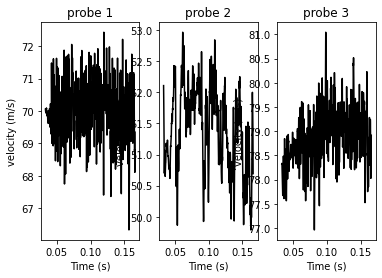

In [5]:
import matplotlib.pyplot as plt
from postpro.read_probe import *

casename = 'notebook2'

probe = read_probe(casename)

plt.figure(1)
for i in range(len(probe)):
    # plot the probe data
    print('Probe ' + str(i+1) + ' position')
    print('x = ', probe[i]['x'])
    print('y = ', probe[i]['y'])
    
    plt.subplot(1,3,i+1)
    plt.plot(probe[i]['time'],probe[i]['vel'],'-k')
    plt.title('probe ' + str(i+1))
    plt.xlabel('Time (s)')
    plt.ylabel('velocity (m/s)')
    
plt.show()



Now check to see if the inflow turbulence is washing into the domain. You will need to re-start the simulation a few times in order for the turbulence to have washed all the way through the domain.

In [174]:
plot_flo(prop,geom,'w',[-1,1])

<module 'matplotlib.pyplot' from '/home/aw329/.local/lib/python3.6/site-packages/matplotlib/pyplot.py'>


---

## 2.4 Gathering statistics

Now we are ready to start gathering statistics. We need to assess the statistical convergence of the flow and we can do that by running the case several times while gathering statistics. We'll set the number of iterations now to $2\times10^5$, so the compute cost per run is doubled - as indicated in the table below.

| VM instance | GPU  | approx. \$/hr*| time per step(s)|\$ for 200k steps* | 
|-------------|------|---------------|--------|----|
| p3.8xlarge  |4 x V100 | 3.6 (12)   | 0.026  | 5.4 (18) | 

*Estimated spot price (values in brackets are the estimated on-demand price) for a 5.4M point grid

The cell below switches the statistics on (istats=2) and adjusts the number of iterations to $2\times10^5$.



In [181]:

# read casefiles
case = read_case(casename)

# adjust iterations 
case['solver']['niter'] = 200000 # total number of iterations
case['solver']['irestart'] = 1 # restart the calculation

case['solver']['istats'] = 2 # switch-on time-averaging (istats=2 does a spanwise average as well for 2D stats)

# write new case files
write_case(case)

Writing inputs for 3dns_gpu
Total ij points
259504
Total GPUs
4


Now re-start the simulation and, as before, make sure to copy all the case files to the directory where you are running the simulations. It is very important to transfer the text files including 'time.txt', since this keeps track of the mean file counter and solution time.

When the simulation is finished you will see 'mean2_#_##' files in the working directory. The number at the end of the file name indicates the nmean counter, which is incremented each time the simulation completes. The text file 'mean_time.txt' stores the integration time for each simulation, and this is appended each time the solution is run.


### Read the mean flow

In [6]:
from postpro.read_2d_mean import *
from postpro.plot_flo import *

casename = 'notebook2'

prop,geom,_=read_2d_mean(casename,[100])




<module 'matplotlib.pyplot' from '/home/aw329/.local/lib/python3.6/site-packages/matplotlib/pyplot.py'>

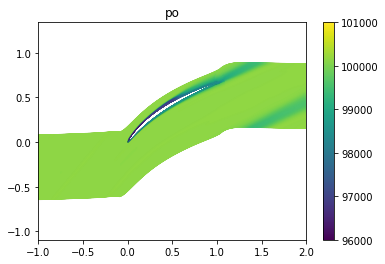

In [7]:

#plot_flo(prop,geom,'mach',[0,0.3])
plot_flo(prop,geom,'po',[0.96e5,1.01e5])



## Statistical convergence

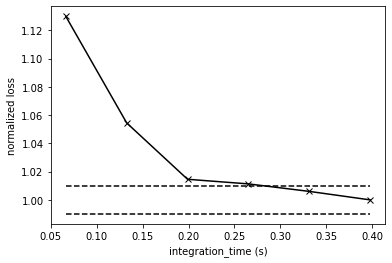

In [10]:
import numpy as np
from postpro.sumvolx import *
from postpro.yp import *

casename = 'notebook2/safe'

nmean = [1,2,3,4,5,6]

inlet = {}
exit = {}

inlet['blocks'] = [1,2]
exit['blocks'] = [8,9]

inlet['x']= -0.5 # avoid buffer regions near inlet bc
exit['x'] = 1.25 # avoid buffer regions near exit bc

loss = np.zeros([len(nmean),1]);
integration_time = np.zeros([len(nmean),1]);

for i,n in enumerate(nmean):
    prop,geom,time=read_2d_mean(casename,[nmean[0],nmean[i]]);
    perf = yp(prop,geom,inlet,exit);
    loss[i] = perf['yp'];
    integration_time[i] = time;

plt.figure(1)    
plt.plot(integration_time,loss/loss[-1],'-kx')
plt.plot(integration_time,np.linspace(1.01,1.01,len(nmean)),'--k')
plt.plot(integration_time,np.linspace(0.99,0.99,len(nmean)),'--k')

plt.ylabel('normalized loss')
plt.xlabel('integration_time (s)')
plt.show()


### Plot the loading

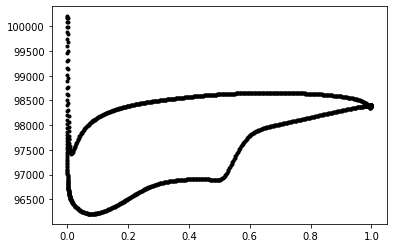

In [11]:
wall_blocks = [3,4,5,7]

plt.figure(1)
for i in wall_blocks:
    plt.plot(geom[i-1]['x'][:,-1],prop[i-1]['p'][:,-1],'k.')

plt.show()

### Plot the wake profile

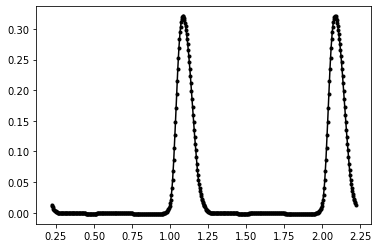

In [15]:

import numpy as np
import matplotlib.pyplot as plt

from postpro.read_2d_mean import *
from postpro.yp import *

# pop-out figures
#%matplotlib qt
%matplotlib inline

casename = 'notebook2/safe'

inlet = {}
exit = {}

inlet['blocks'] = [1,2]
exit['blocks'] = [8,9]

inlet['x']= -0.5 # avoid buffer regions near inlet bc
exit['x'] = 1.25 # avoid buffer regions near exit bc

plt.figure(1)
prop,geom,time=read_2d_mean(casename,[100]);
perf = yp(prop,geom,inlet,exit);
wake = perf['wake']

plt.plot(wake['y'],wake['yp'],'-k.')
# periodic repeat
plt.plot(wake['y']+1,wake['yp'],'-k.')
Yp = perf['yp']
    
plt.show()



### Check resolution

In [16]:
from postpro.boundarylayer import *


bl =boundarylayer(casename,[100]);


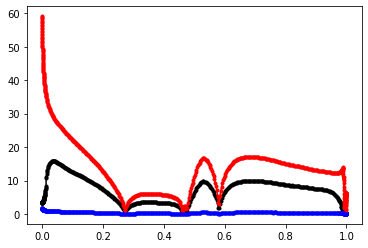

In [18]:
plt.figure(1)
plt.plot(bl['ss']['x'],bl['ss']['xplus'],'-k.')
plt.plot(bl['ss']['x'],bl['ss']['yplus'],'-b.')
plt.plot(bl['ss']['x'],bl['ss']['zplus'],'-r.')

plt.show()

### Check spectrum

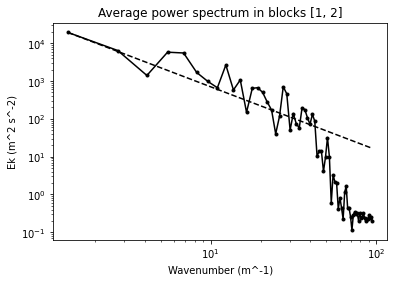

In [20]:
from postpro.plot_spectrum import *


casename = 'notebook2'

plot_spectrum(casename,[1,2],20);